# 1. GEREKLİ KÜTÜPHANELER

In [80]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import mediapipe as mp
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from datetime import datetime
from PIL import Image, ImageDraw, ImageFont

# 2. MP HOLİSTİC İLE ANAHTAR NOKTA ÇIKARMA 

In [3]:
# mp.solutions.holistic, Mediapipe kütüphanesinin bütünsel (holistic) modelini temsil eder.
mp_holistic = mp.solutions.holistic  # Bütünsel model

# mp.solutions.drawing_utils, Mediapipe kütüphanesinin çizim yardımcı fonksiyonlarını içerir.
mp_drawing = mp.solutions.drawing_utils  # Çizim yardımcı fonksiyonları


In [4]:
def mediapipe_detection(image, model):
    """
    Mediapipe modelini kullanarak görüntü üzerinde nesne algılama yapar.

    Parameters:
        image (numpy.ndarray): Görüntü.
        model: Mediapipe modeli (örneğin, holistic model, hand model).

    Returns:
        tuple: İşlenmiş görüntü ve modelin algılama sonuçları.
    """
    # Görüntüyü RGB formatına dönüştürme
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # RENK DÖNÜŞÜMÜ BGR'den RGB'ye

    # Görüntüyü yazılabilir olmaktan çıkarma
    image.flags.writeable = False  # Görüntü artık yazılabilir değil

    # Modeli kullanarak tahmin yapma
    results = model.process(image)  # Tahmin yapma

    # Görüntüyü yazılabilir hale getirme
    image.flags.writeable = True  # Görüntü artık yazılabilir

    # Görüntüyü RGB formatından BGR formatına dönüştürme
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # RENK DÖNÜŞÜMÜ RGB'den BGR'ye

    # İşlenmiş görüntü ve algılama sonuçlarını tuple olarak döndürme
    return image, results


In [5]:
def draw_styled_landmarks(image, results):
    """
    Stilize edilmiş bir şekilde el bağlantı çizgilerini görüntü üzerine çizer.

    Parameters:
        image (numpy.ndarray): Görüntü.
        results: Mediapipe modelinin algılama sonuçları.

    Returns:
        None
    """
    # Sol elin bağlantı çizgilerini çizme
    mp_drawing.draw_landmarks(
        image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
        mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=2)
    )

    # Sağ elin bağlantı çizgilerini çizme
    mp_drawing.draw_landmarks(
        image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
        mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
    )


In [6]:


# Video akışını başlat
cap = cv2.VideoCapture(0)

# Mediapipe bütünsel (holistic) modelini başlat
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Görüntüyü oku
        ret, frame = cap.read()

        # Mediapipe modeli ile algılama yap
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Algılanan özellikleri stilize edilmiş bir şekilde görüntü üzerine çiz
        draw_styled_landmarks(image, results)

        # Ekran üzerinde göster
        cv2.imshow('OpenCV Feed', image)

        #  çıkış
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

# Kaynakları serbest bırak
cap.release()
cv2.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [7]:
# Sol elin landmark noktalarının sayısını bulma
len(results.left_hand_landmarks.landmark)



21

In [8]:
 # Mediapipe modeli ile yapılan algılama sonuçları
results  
print(results)

<class 'mediapipe.python.solution_base.SolutionOutputs'>


In [9]:
# Algılanan landmark noktalarını ve bağlantı çizgilerini çizme
draw_styled_landmarks(frame, results)


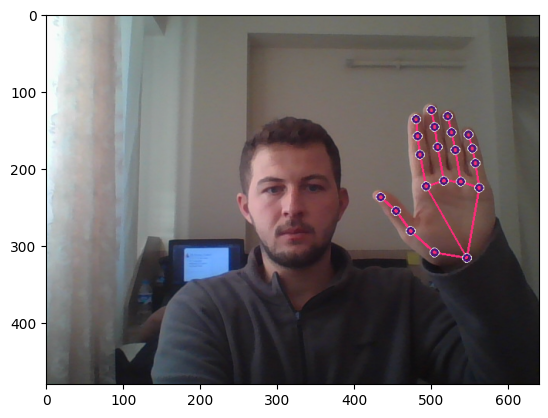

In [10]:
# Görüntüyü RGB formatına dönüştürerek ekrana gösterme
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()

# 3. ANAHTAR NOKTA DEĞERLERİNİ ÇIKARMA

In [6]:
def extract_keypoints(results):
    # Sol elin 3D koordinatlarını düzleştirip tek bir satırda sıralama
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)

    # Sağ elin 3D koordinatlarını düzleştirip tek bir satırda sıralama
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    
     # Sol ve sağ elin koordinatlarını birleştirme
    return np.concatenate([ lh, rh])

In [12]:
# extract_keypoints fonksiyonunu kullanarak results değişkeninden sol ve sağ elin 3D koordinatlarını çıkartma
result_test = extract_keypoints(results)

In [13]:
result_test

array([ 8.53736103e-01,  6.60053253e-01,  3.21479490e-07,  7.88141429e-01,
        6.43920958e-01, -2.23333314e-02,  7.39896536e-01,  5.86976111e-01,
       -3.19047719e-02,  7.10095465e-01,  5.31960964e-01, -3.98733057e-02,
        6.78428173e-01,  4.94213998e-01, -4.73952293e-02,  7.71279275e-01,
        4.65101749e-01, -1.13958474e-02,  7.58249104e-01,  3.80169749e-01,
       -2.56109722e-02,  7.53534615e-01,  3.29995453e-01, -3.97666954e-02,
        7.50175655e-01,  2.84866869e-01, -5.05037121e-02,  8.07252407e-01,
        4.50496495e-01, -1.33645684e-02,  7.94562221e-01,  3.59051079e-01,
       -2.22866852e-02,  7.87812233e-01,  3.05674136e-01, -3.31598185e-02,
        7.82157481e-01,  2.60382116e-01, -4.24768254e-02,  8.41811001e-01,
        4.53760087e-01, -1.92303378e-02,  8.30823183e-01,  3.67927313e-01,
       -2.85602547e-02,  8.22990119e-01,  3.19348931e-01, -3.50195356e-02,
        8.14709008e-01,  2.76702940e-01, -4.11245264e-02,  8.78457189e-01,
        4.69647467e-01, -

In [15]:
# NumPy dizisini '0.npy' adlı bir dosyaya kaydetme
np.save('0.npy', result_test)


In [47]:
# '0.npy' adlı NumPy dosyasını yükleme
np.load('0.npy')


array([ 8.53736103e-01,  6.60053253e-01,  3.21479490e-07,  7.88141429e-01,
        6.43920958e-01, -2.23333314e-02,  7.39896536e-01,  5.86976111e-01,
       -3.19047719e-02,  7.10095465e-01,  5.31960964e-01, -3.98733057e-02,
        6.78428173e-01,  4.94213998e-01, -4.73952293e-02,  7.71279275e-01,
        4.65101749e-01, -1.13958474e-02,  7.58249104e-01,  3.80169749e-01,
       -2.56109722e-02,  7.53534615e-01,  3.29995453e-01, -3.97666954e-02,
        7.50175655e-01,  2.84866869e-01, -5.05037121e-02,  8.07252407e-01,
        4.50496495e-01, -1.33645684e-02,  7.94562221e-01,  3.59051079e-01,
       -2.22866852e-02,  7.87812233e-01,  3.05674136e-01, -3.31598185e-02,
        7.82157481e-01,  2.60382116e-01, -4.24768254e-02,  8.41811001e-01,
        4.53760087e-01, -1.92303378e-02,  8.30823183e-01,  3.67927313e-01,
       -2.85602547e-02,  8.22990119e-01,  3.19348931e-01, -3.50195356e-02,
        8.14709008e-01,  2.76702940e-01, -4.11245264e-02,  8.78457189e-01,
        4.69647467e-01, -

# 4. VERİ TOPLAMA VE KLASÖRLERİ AYARLAMA 

In [7]:
# Verinin saklanacağı dizin yolu
DATA_PATH = os.path.join('Data')

# Algılamaya çalıştığımız eylemler
actions = np.array(['0','1','2','3','4','5','6','7','8','9','A','B','C','Ç','D','E','F','G','Ğ','H','I','İ','J','K','L','M','N','O','Ö','P','R','S','Ş','T','U','Ü','V','Y','Z'])

# Toplamda 30 video dizisi
no_sequences = 30

# Her bir video dizisi 30 çerçeve içerecek
sequence_length = 30


In [ ]:
# Her bir eylem ve her bir video dizisi için klasör oluşturma
for action in actions:
    for sequence in range(no_sequences):
        try:
            # Eğer klasör yoksa oluştur
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            # Eğer klasör zaten varsa geç (pass)
            pass

# 5. EĞİTİM VE TEST İÇİN ANAHTAR NOKTA DEĞERLERİNİ TOPLAMA 

In [ ]:
# Kamera akışını başlat
cap = cv2.VideoCapture(0)

# Mediapipe modelini ayarla
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # Eylemleri döngü içinde gez
    for action in actions:
        
        # Videoları (video dizilerini) döngü içinde gez
        for sequence in range(no_sequences):
            
            # Çerçeve uzunluğunu (sequence length) döngü içinde gez
            for frame_num in range(sequence_length):

                # Kameradan görüntüyü oku
                ret, frame = cap.read()

                # Algılamaları yap
                image, results = mediapipe_detection(frame, holistic)
                
                # Landmark noktalarını çiz
                draw_styled_landmarks(image, results)
                
                # Sayaç bilgilerini ekrana yazdır
                cv2.putText(image, 'Video: {}  Frame: {}'.format(sequence, frame_num), (15, 30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
                
                # YENİ Bekleme mantığı uygula
                if frame_num == 0: 
                    cv2.putText(image, 'BASLİYOR', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, '{} Video Numarasi icin cerceveler toplaniyor'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Ekrana göster
                    cv2.imshow('OpenCV Akisi', image)
                    cv2.waitKey(400)
                else: 
                    cv2.putText(image, '{} Video Numarasi icin cerceveler toplaniyor'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Ekrana göster
                    cv2.imshow('OpenCV Akisi', image)
                
                # YENİ Keypoint'leri dışa aktar
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Graceful çıkış
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    # Kamerayı serbest bırak
    cap.release()
    cv2.destroyAllWindows()



# 6. VERİYİ ÖN İŞLEME VE ETİKETLER İLE ÖZELLİKLERİ OLUŞTURMA

In [48]:
label_map = {label:num for num, label in enumerate(actions)}# Etiketleme haritası oluşturma

In [49]:
label_map

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'A': 10,
 'B': 11,
 'C': 12,
 'Ç': 13,
 'D': 14,
 'E': 15,
 'F': 16,
 'G': 17,
 'Ğ': 18,
 'H': 19,
 'I': 20,
 'İ': 21,
 'J': 22,
 'K': 23,
 'L': 24,
 'M': 25,
 'N': 26,
 'O': 27,
 'Ö': 28,
 'P': 29,
 'R': 30,
 'S': 31,
 'Ş': 32,
 'T': 33,
 'U': 34,
 'Ü': 35,
 'V': 36,
 'Y': 37,
 'Z': 38}

In [50]:
# Her bir eylem için belirtilen sayıda video dizisi oluşturarak, her bir çerçeve için elin 3D koordinatlarını içeren özellik vektörleri ve etiketleri oluştur.
sequences, labels = [], []

# Her bir eylemi gez
for action in actions:
    # Belirtilen sayıda video dizisi oluştur
    for sequence in range(no_sequences):
        # Her bir video dizisi için çerçeveleri gez
        window = []
        for frame_num in range(sequence_length):
            # Her bir çerçeve için elin 3D koordinatlarını içeren özellik vektörünü yükle
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        # Oluşturulan özellik vektörlerini listeye ekle
        sequences.append(window)
        # Her bir video dizisi için etiketi listeye ekle (etiket, eylemin numarasıdır)
        labels.append(label_map[action])


In [51]:
# Oluşturulan veri kümesini NumPy dizisine dönüştür ve dizinin boyutlarını göster
np.array(sequences).shape


(1170, 30, 126)

In [52]:
# Oluşturulan etiket listesini NumPy dizisine dönüştür ve dizinin boyutlarını göster
np.array(labels).shape


(1170,)

In [53]:
# Oluşturulan veri kümesini NumPy dizisine dönüştür ve X adlı değişkene atayın
X = np.array(sequences)

In [54]:
X.shape

(1170, 30, 126)

In [55]:
# Etiketleri kategorik formata dönüştür ve ardından int türüne dönüştür
y = to_categorical(labels).astype(int)

In [58]:
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [57]:
# Veri setini eğitim ve test setlerine bölmek
# X: Giriş verileri, y: Etiketler, test_size: Test setinin oranı (0.05 = %5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [59]:
y_test.shape

(234, 39)

# 7.LSTM SİNİR AĞI OLUŞTURMA VE EĞİTME

In [60]:
# Kayıt dosyalarının saklanacağı dizin yolu
log_dir = os.path.join('Log/train')

# TensorBoard geri çağrısını oluştur
tb_callback = TensorBoard(log_dir=log_dir)


In [61]:

# Sıralı model oluştur
model = Sequential()

# LSTM katmanları ekleyerek modeli tanımla
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 126)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))

# Yoğun (dense) katmanlar ekleyerek modeli tanımla
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Çıkış katmanı ekleyerek modeli tamamla
model.add(Dense(actions.shape[0], activation='softmax'))

In [62]:
res = [.7, 0.2, 0.1]

In [63]:
# Modeli derleme işlemi
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [68]:

# Modeli eğitirken X_train ve y_train verilerini kullan, eğitim süresini 2000 epoch boyunca gerçekleştir.
# TensorBoard geri çağrısı ile eğitim sırasında logları kaydet.
model.fit(X_train, y_train, epochs=1200, callbacks=[tb_callback])



Epoch 1/1200


30/30 [==============================] - 6s 34ms/step - loss: 3.6146 - categorical_accuracy: 0.0491
Epoch 2/1200
30/30 [==============================] - 1s 35ms/step - loss: 3.4133 - categorical_accuracy: 0.0566
Epoch 3/1200
30/30 [==============================] - 1s 33ms/step - loss: 3.1772 - categorical_accuracy: 0.0673
Epoch 4/1200
30/30 [==============================] - 1s 34ms/step - loss: 2.9555 - categorical_accuracy: 0.0694
Epoch 5/1200
30/30 [==============================] - 1s 34ms/step - loss: 2.8565 - categorical_accuracy: 0.0887
Epoch 6/1200
30/30 [==============================] - 1s 34ms/step - loss: 2.5731 - categorical_accuracy: 0.1335
Epoch 7/1200
30/30 [==============================] - 1s 36ms/step - loss: 2.6285 - categorical_accuracy: 0.1282
Epoch 8/1200
30/30 [==============================] - 1s 35ms/step - loss: 2.4440 - categorical_accuracy: 0.1613
Epoch 9/1200
30/30 [==============================] - 1s 33ms/step - loss: 2.3394 - categorica

In [64]:
# Modelin özetini görüntüle
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 64)            48896     
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 39)                1287      
                                                                 
Total params: 204647 (799.40 KB)
Trainable params: 204

# 8. TAHMİNLER

In [66]:
# Modeli kullanarak X_test verileri üzerinde tahminleme yap
res = model.predict(X_test)


8/8 [==============================] - 1s 13ms/step


In [67]:
# Tahmin vektöründeki en büyük değere sahip olan sınıfın adını belirle
predicted_class = actions[np.argmax(res[5])]


In [68]:
predicted_class

'L'

In [69]:
# Gerçek etiket vektöründeki en büyük değere sahip olan sınıfın adını belirle
true_class = actions[np.argmax(y_test[5])]


In [70]:
true_class

'L'

# 9. MODEL KAYDETME 

In [39]:
# Eğitilmiş modeli kaydet
model.save('model.h5')


c:\Users\work\Desktop\TurkisaretDiliTanima\myenv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [65]:
# Önceden kaydedilmiş ağırlıkları yükleyerek modeli 'action.h5' dosyasından geri yükle
model.load_weights('model.h5')


# 10. KARMAŞIKLIK MATRİSİ VE DOĞRULUK DEĞERİ 

In [71]:
# Modeli kullanarak X_test verileri üzerinde tahminleme yap
yhat = model.predict(X_test)


8/8 [==============================] - 0s 14ms/step


In [72]:
# Gerçek etiketleri (y_true) ve tahmin edilen etiketleri (y_hat) liste formatına dönüştür
y_true = np.argmax(y_test, axis=1).tolist()
y_hat = np.argmax(yhat, axis=1).tolist()


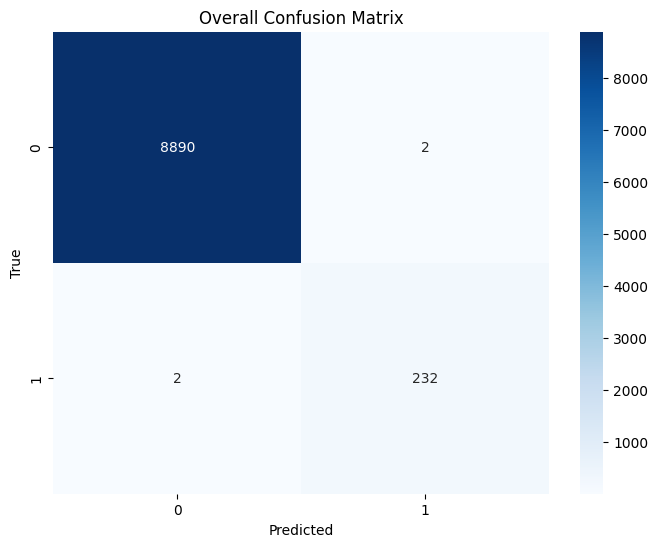

In [73]:

# Tüm sınıflar için çoklu etiketli karışıklık matrisini hesapla
confusion_matrices = multilabel_confusion_matrix(y_true, y_hat)

# Tüm matrisleri topla
total_confusion_matrix = np.sum(confusion_matrices, axis=0)

# Genel karışıklık matrisini görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(total_confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Overall Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



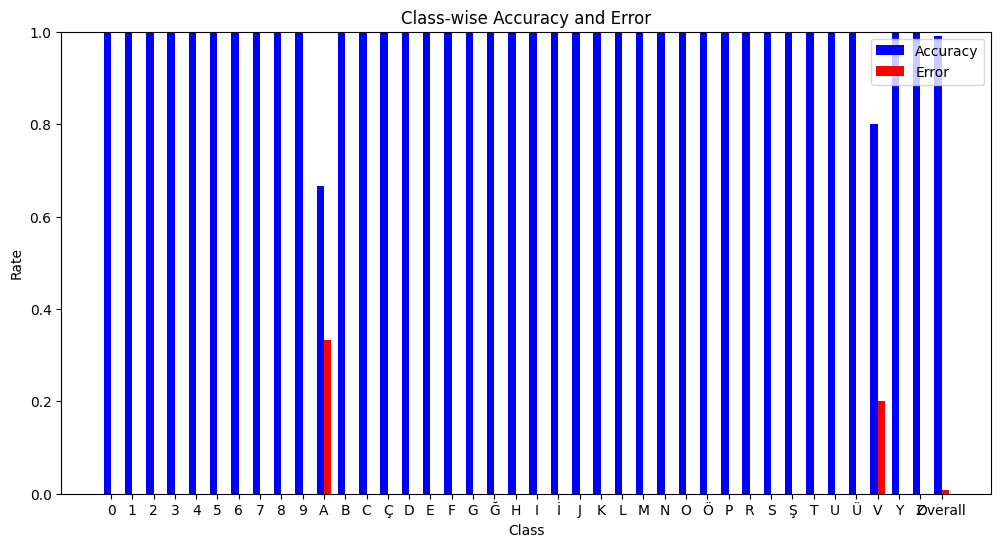

In [74]:
# Doğruluk oranlarını hesapla
accuracy = accuracy_score(y_true, y_hat)

# Her sınıf için doğruluk ve hata oranlarını topla
class_accuracies = []
class_errors = []
for i in range(len(actions)):
    class_accuracy = accuracy_score(np.array(y_true)[np.array(y_true) == i], np.array(y_hat)[np.array(y_true) == i])
    class_error = 1 - class_accuracy
    class_accuracies.append(class_accuracy)
    class_errors.append(class_error)

# Genel doğruluk ve hata oranlarını ekle
class_accuracies.append(accuracy)
class_errors.append(1 - accuracy)

# Sınıf adlarını ve genel doğruluk ile hata oranlarını görselleştir
plt.figure(figsize=(12, 6))
actions_with_overall = np.append(actions, 'Overall')
class_accuracies_float = [float(acc) for acc in class_accuracies]
class_errors_float = [float(err) for err in class_errors]
bar_width = 0.35
index = np.arange(len(actions_with_overall))

plt.bar(index, class_accuracies_float, bar_width, label='Accuracy', color='blue')
plt.bar(index + bar_width, class_errors_float, bar_width, label='Error', color='red')

plt.title('Class-wise Accuracy and Error')
plt.xlabel('Class')
plt.ylabel('Rate')
plt.xticks(index + bar_width / 2, actions_with_overall)
plt.legend()
plt.ylim(0, 1)  # Y eksenini [0, 1] aralığında tut
plt.show()


In [75]:
accuracy

0.9914529914529915

# 11. GERÇEK ZAMANLI TEST


In [82]:
font_path = "C:\\Users\\work\\Desktop\\TurkAlfabesi-IsaretDili\\Tinos-Regular.ttf"
font_size = 50  # Yazı tipi boyutu

# Kamera akışını başlat
cap = cv2.VideoCapture(0)

# Medipipe Holistic ile El Hareketlerini Tanıma ve Tahmin Etme
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.3)

# El hareketi algılanmadığı durumu kontrol etmek için bir uyarı mesajı
no_gesture_message = "El Algılanmadı"


while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Medipipe ile el hareketlerini tespit et
    image, results = mediapipe_detection(frame, holistic)

    # El hareketlerini çerçeveye al ve tahminde bulun
    draw_styled_landmarks(image, results)
    keypoints = extract_keypoints(results)

    # Giriş verisini modelin beklediği şekle getir
    input_features = np.expand_dims(np.array([keypoints] * 30), axis=0)

    # Tahmin yap
    prediction = model.predict(input_features)

    # Tahmin sonucunu al
    action_text = actions[np.argmax(prediction)]

    # Metni resme yazdırma işlemi
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(pil_image)
    font = ImageFont.truetype(font_path, font_size)
    draw.text((10, 30), action_text, font=font, fill=(0, 0, 255))

    # Eğer el hareketi algılanmadıysa uyarı mesajını ekrana yazdır
    if action_text == "No Gesture":
        draw.text((10, 60), no_gesture_message, font=font, fill=(0, 0, 255))
    else:
        # El hareketi algılandıysa, uyarı mesajını temizle
        draw.text((10, 60), "", font=font, fill=(0, 0, 255))

      
      # Çerçeveyi göster
    cv2.imshow('Gercek zamanli tanima', cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR))

    # Çıkış için 'q' tuşuna basın
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

# Kamerayı serbest bırak
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 30ms/step
